In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2


In [2]:
from nips2018.movie import data, parameters, models
from nips2018.movie.analysis import performance
import pandas as pd
import seaborn as sns
import datajoint as dj
import numpy as np
import matplotlib.pyplot as plt
from nips2018.movie.analysis import tuning
from contextlib import contextmanager
import pycircstat as circ
from config import movie_vs_noise_cmap, fix_axis, scan_order, scan_cmap, performance_yticks, performance_ylim, strike
from skimage.transform import resize
from nips2018.movie import oracle

@contextmanager
def silence():
    old_stdout = sys.stdout
    sys.stdout = open('/dev/null', 'w')
    try:
        yield
    finally:
        sys.stdout = old_stdout
        
groups = [21, 22, 23]
group_constr = 'group_id in ({})'.format(','.join([str(e) for e in groups]))


/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Connecting fabee@10.28.0.34:3306


/src/Sinz2018_NIPS/nips2018/architectures/cores.py:18: UserWarning: Could not import CajalUnit. You won't be able to use the NetGardCore
  warn("Could not import CajalUnit. You won't be able to use the NetGardCore")


# Difference in preferred orientation

In [3]:
group_ids = [21,22,23]
group_constr = 'group_id in ({})'.format(','.join(tuple(map(str, group_ids))))
base = {'core_hash': '22d11147b37e3947e7d1034cc00d402c', # 12 x 36
     'seed': 2606,
     'train_hash': '624f62a2ef01d39f6703f3491bb9242b', # batchsize=8 stop gradient
     'ro_hash':'bf00321c11e46d68d4a42653a725969d', # 2 and 4 
    }
network_configs0 = dj.AndList([
    base,
    'mod_hash in ("4954311aa3bebb347ebf411ab5198890")',
    'shift_hash in ("64add03e1462b7413b59812d446aee9f")',
    'data_hash in ("5253599d3dceed531841271d6eeba9c5", "6c0290da908317e55c4baf92e379d651")',
    group_constr
])
network_configs1 = dj.AndList([
    base,
    'mod_hash in ("bafd7322c6e97d25b6299b5d6fe8920b")',
    'shift_hash in ("bafd7322c6e97d25b6299b5d6fe8920b")',
    'data_hash in ("5253599d3dceed531841271d6eeba9c5", "6c0290da908317e55c4baf92e379d651")',
    group_constr
])
network_configs = [network_configs0, network_configs1]



In [4]:
tuning.MonetResponse().populate(network_configs)

In [5]:
tuning.MonetOri().populate(network_configs)

In [6]:
tuning.MonetOri() & network_configs & dict(ori_type='ori')

group_id index of group,core_hash unique identifier for configuration,ro_hash unique identifier for configuration,shift_hash unique identifier for configuration,mod_hash unique identifier for configuration,data_hash unique identifier for configuration,train_hash unique identifier for configuration,seed random seed,ori_type orientation (180 degrees) or direction (360 degrees),latency (s) screen-to-brain latency,duration (s) total duration of applicable trials
21,22d11147b37e3947e7d1034cc00d402c,bf00321c11e46d68d4a42653a725969d,64add03e1462b7413b59812d446aee9f,4954311aa3bebb347ebf411ab5198890,5253599d3dceed531841271d6eeba9c5,624f62a2ef01d39f6703f3491bb9242b,2606,ori,0.05,7.504
21,22d11147b37e3947e7d1034cc00d402c,bf00321c11e46d68d4a42653a725969d,64add03e1462b7413b59812d446aee9f,4954311aa3bebb347ebf411ab5198890,6c0290da908317e55c4baf92e379d651,624f62a2ef01d39f6703f3491bb9242b,2606,ori,0.05,7.504
21,22d11147b37e3947e7d1034cc00d402c,bf00321c11e46d68d4a42653a725969d,bafd7322c6e97d25b6299b5d6fe8920b,bafd7322c6e97d25b6299b5d6fe8920b,5253599d3dceed531841271d6eeba9c5,624f62a2ef01d39f6703f3491bb9242b,2606,ori,0.05,7.504
21,22d11147b37e3947e7d1034cc00d402c,bf00321c11e46d68d4a42653a725969d,bafd7322c6e97d25b6299b5d6fe8920b,bafd7322c6e97d25b6299b5d6fe8920b,6c0290da908317e55c4baf92e379d651,624f62a2ef01d39f6703f3491bb9242b,2606,ori,0.05,7.504
22,22d11147b37e3947e7d1034cc00d402c,bf00321c11e46d68d4a42653a725969d,64add03e1462b7413b59812d446aee9f,4954311aa3bebb347ebf411ab5198890,5253599d3dceed531841271d6eeba9c5,624f62a2ef01d39f6703f3491bb9242b,2606,ori,0.05,7.504
22,22d11147b37e3947e7d1034cc00d402c,bf00321c11e46d68d4a42653a725969d,64add03e1462b7413b59812d446aee9f,4954311aa3bebb347ebf411ab5198890,6c0290da908317e55c4baf92e379d651,624f62a2ef01d39f6703f3491bb9242b,2606,ori,0.05,7.504
22,22d11147b37e3947e7d1034cc00d402c,bf00321c11e46d68d4a42653a725969d,bafd7322c6e97d25b6299b5d6fe8920b,bafd7322c6e97d25b6299b5d6fe8920b,5253599d3dceed531841271d6eeba9c5,624f62a2ef01d39f6703f3491bb9242b,2606,ori,0.05,7.504


## Orientation Tuning

In [7]:
rel_cell = tuning.Ori.Cell() & dict(stimulus_type="stimulus.Monet2", ori_type='ori', spike_method=5, segmentation_method=3, ori_version=3) & 'selectivity > .2 and r2 > 0.005' & (data.MovieMultiDataset.Member() & group_constr)
df_cell = pd.DataFrame(rel_cell.fetch())
rel_model = tuning.MonetOri.Cell().proj(model_angle='angle', train_data='IF(data_hash = "5253599d3dceed531841271d6eeba9c5", "movies", "noise")') & network_configs
df_model = pd.DataFrame(rel_model.fetch())
df_model['model'] = ['full' if not (r.shift_hash == 'bafd7322c6e97d25b6299b5d6fe8920b' and (r.mod_hash == 'bafd7322c6e97d25b6299b5d6fe8920b')) else strike('shifter/modulator') for _, r in df_model.iterrows()]
df = df_cell.merge(df_model, on=['animal_id', 'session', 'scan_idx', 'unit_id', 'ori_type'])
df = df.drop([e for e in df.columns if 'hash' in e], axis=1)
df[:10]

,animal_id,session,scan_idx,pipe_version,field,channel,segmentation_method,spike_method,stimulus_type,ori_type,unit_id,variance,angle,selectivity,r2,group_id,seed,model_angle,train_data,model
0,17797,8,5,1,1,1,3,5,stimulus.Monet2,ori,132,36.4499,1.060960,0.393241,0.005514,21,2606,-1.556200,movies,full
1,17797,8,5,1,1,1,3,5,stimulus.Monet2,ori,132,36.4499,1.060960,0.393241,0.005514,21,2606,1.173000,noise,full
2,17797,8,5,1,1,1,3,5,stimulus.Monet2,ori,132,36.4499,1.060960,0.393241,0.005514,21,2606,1.491360,movies,s̶h̶i̶f̶t̶e̶r̶/̶m̶o̶d̶u̶l̶a̶t̶o̶r̶
3,17797,8,5,1,1,1,3,5,stimulus.Monet2,ori,132,36.4499,1.060960,0.393241,0.005514,21,2606,1.169490,noise,s̶h̶i̶f̶t̶e̶r̶/̶m̶o̶d̶u̶l̶a̶t̶o̶r̶
4,17797,8,5,1,1,1,3,5,stimulus.Monet2,ori,137,302.1040,0.251698,0.558885,0.018036,21,2606,-0.041284,movies,full
5,17797,8,5,1,1,1,3,5,stimulus.Monet2,ori,137,302.1040,0.251698,0.558885,0.018036,21,2606,0.224921,noise,full
6,17797,8,5,1,1,1,3,5,stimulus.Monet2,ori,137,302.1040,0.251698,0.558885,0.018036,21,2606,-0.068694,movies,s̶h̶i̶f̶t̶e̶r̶/̶m̶o̶d̶u̶l̶a̶t̶o̶r̶
7,17797,8,5,1,1,1,3,5,stimulus.Monet2,ori,137,302.1040,0.251698,0.558885,0.018036,21,2606,0.239661,noise,s̶h̶i̶f̶t̶e̶r̶/̶m̶o̶d̶u̶l̶a̶t̶o̶r̶
8,17797,8,5,1,1,1,3,5,stimulus.Monet2,ori,152,12.1632,0.033552,0.469343,0.008218,21,2606,-0.151626,movies,full
9,17797,8,5,1,1,1,3,5,stimulus.Monet2,ori,152,12.1632,0.033552,0.469343,0.008218,21,2606,-0.046583,noise,full


In [8]:
df['scan'] = ['{animal_id}-{session}-{scan_idx}'.format(**r.to_dict()) for _, r in df.iterrows()]
df[r'$\Delta \phi$'] = circ.cdiff(2 * df.angle, 2 * df.model_angle) / 2


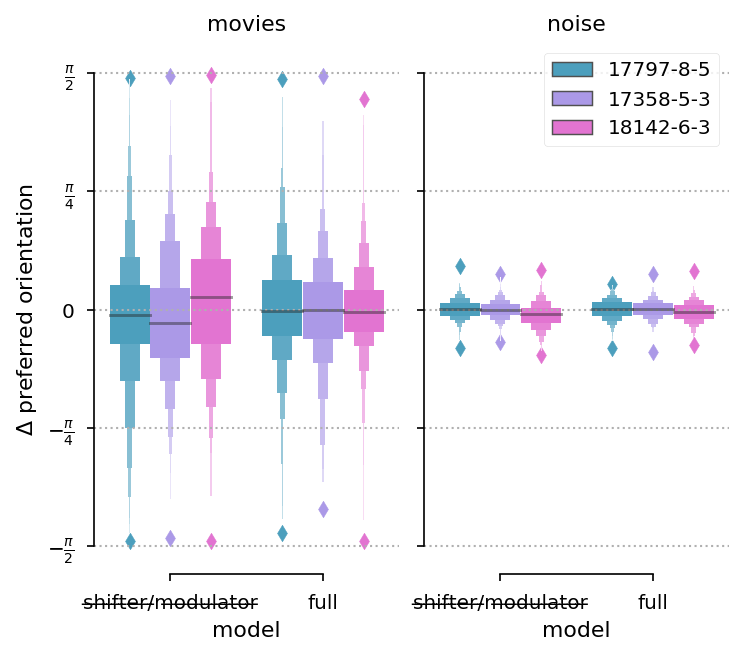

In [9]:
sns.set_context('paper', font_scale=1.2)

sns.set_palette(scan_cmap)
g = sns.factorplot("model",  r'$\Delta \phi$', hue='scan', data=df, kind='lv', 
                   col='train_data', legend=False, order=[strike('shifter/modulator'), "full"])
g.fig.set_dpi(150)
g.axes[0,0].set_yticks([-np.pi/2,-np.pi/4,0,np.pi/4,np.pi/2])
g.axes[0,0].set_yticklabels([r'$-\frac{\pi}{2}$', r'$-\frac{\pi}{4}$', '0', r'$\frac{\pi}{4}$', r'$\frac{\pi}{2}$'])
# g.set_xlabels("")
g.axes[0,0].set_ylabel(r'$\Delta$ preferred orientation')
g.axes[0,0].yaxis.grid(linestyle=':', zorder=-20, lw=1)
g.axes[0,1].yaxis.grid(linestyle=':', zorder=-20, lw=1)
g.axes[0,1].legend(ncol=1)
g.set_titles("{col_name}")
g.fig.set_size_inches((5,5))
sns.despine(trim=True)
g.fig.subplots_adjust(bottom=.2, left=.125)
g.fig.savefig('figures/delta_ori_lv.png', dpi=200)

#  Shifter vs. Modulator

In [10]:
from scipy.stats import levene

def test(d):
    return pd.Series({'p-value':levene(d['full'], d[strike('shifter/modulator')])[1]})

df2 = df.groupby(['train_data', 'scan', 'model'])[r'$\Delta \phi$'].std().unstack('model')
df2['ratio'] = df2.loc[:, strike('shifter/modulator')]/df2.loc[:, 'full']

df3 = df.set_index(['train_data', 'scan','unit_id',  'model'])[r'$\Delta \phi$'].unstack('model').reset_index()
df3 = df3.groupby(['train_data', 'scan']).apply(test)
df2['p-value'] = df3['p-value']
df2

model                     full  s̶h̶i̶f̶t̶e̶r̶/̶m̶o̶d̶u̶l̶a̶t̶o̶r̶     ratio  \
train_data scan                                                                
movies     17358-5-3  0.391910                            0.430588  1.098691   
           17797-8-5  0.385236                            0.447983  1.162879   
           18142-6-3  0.318263                            0.473330  1.487231   
noise      17358-5-3  0.060836                            0.061660  1.013542   
           17797-8-5  0.066317                            0.065776  0.991842   
           18142-6-3  0.069959                            0.088225  1.261093   

model                      p-value  
train_data scan                     
movies     17358-5-3  2.854298e-02  
           17797-8-5  1.250210e-03  
           18142-6-3  4.573055e-12  
noise      17358-5-3  6.380130e-01  
           17797-8-5  3.899909e-01  
           18142-6-3  6.356972e-04

## Direction tuning

In [11]:
tuning.MonetOri() & network_configs & dict(ori_type='dir', ori_version=3)

group_id index of group,core_hash unique identifier for configuration,ro_hash unique identifier for configuration,shift_hash unique identifier for configuration,mod_hash unique identifier for configuration,data_hash unique identifier for configuration,train_hash unique identifier for configuration,seed random seed,ori_type orientation (180 degrees) or direction (360 degrees),latency (s) screen-to-brain latency,duration (s) total duration of applicable trials
21,22d11147b37e3947e7d1034cc00d402c,bf00321c11e46d68d4a42653a725969d,64add03e1462b7413b59812d446aee9f,4954311aa3bebb347ebf411ab5198890,5253599d3dceed531841271d6eeba9c5,624f62a2ef01d39f6703f3491bb9242b,2606,dir,0.05,7.504
21,22d11147b37e3947e7d1034cc00d402c,bf00321c11e46d68d4a42653a725969d,64add03e1462b7413b59812d446aee9f,4954311aa3bebb347ebf411ab5198890,6c0290da908317e55c4baf92e379d651,624f62a2ef01d39f6703f3491bb9242b,2606,dir,0.05,7.504
21,22d11147b37e3947e7d1034cc00d402c,bf00321c11e46d68d4a42653a725969d,bafd7322c6e97d25b6299b5d6fe8920b,bafd7322c6e97d25b6299b5d6fe8920b,5253599d3dceed531841271d6eeba9c5,624f62a2ef01d39f6703f3491bb9242b,2606,dir,0.05,7.504
21,22d11147b37e3947e7d1034cc00d402c,bf00321c11e46d68d4a42653a725969d,bafd7322c6e97d25b6299b5d6fe8920b,bafd7322c6e97d25b6299b5d6fe8920b,6c0290da908317e55c4baf92e379d651,624f62a2ef01d39f6703f3491bb9242b,2606,dir,0.05,7.504
22,22d11147b37e3947e7d1034cc00d402c,bf00321c11e46d68d4a42653a725969d,64add03e1462b7413b59812d446aee9f,4954311aa3bebb347ebf411ab5198890,5253599d3dceed531841271d6eeba9c5,624f62a2ef01d39f6703f3491bb9242b,2606,dir,0.05,7.504
22,22d11147b37e3947e7d1034cc00d402c,bf00321c11e46d68d4a42653a725969d,64add03e1462b7413b59812d446aee9f,4954311aa3bebb347ebf411ab5198890,6c0290da908317e55c4baf92e379d651,624f62a2ef01d39f6703f3491bb9242b,2606,dir,0.05,7.504
22,22d11147b37e3947e7d1034cc00d402c,bf00321c11e46d68d4a42653a725969d,bafd7322c6e97d25b6299b5d6fe8920b,bafd7322c6e97d25b6299b5d6fe8920b,5253599d3dceed531841271d6eeba9c5,624f62a2ef01d39f6703f3491bb9242b,2606,dir,0.05,7.504


In [12]:
# rel_cell = tune.Ori.Cell() & dict(stimulus_type="stimulus.Monet2", ori_type='dir', spike_method=5, segmentation_method=3, ori_version=3) & '1/(2/selectivity-1) > .1 and r2 > 0.002' & (data.MovieMultiDataset.Member() & group_constr)
rel_cell = tuning.Ori.Cell() & dict(stimulus_type="stimulus.Monet2", ori_type='dir', spike_method=5, segmentation_method=3, ori_version=3) & 'selectivity > .1 and r2 > 0.002' & (data.MovieMultiDataset.Member() & group_constr)
df_cell = pd.DataFrame(rel_cell.fetch())
rel_model = tuning.MonetOri.Cell().proj(model_angle='angle', train_data='IF(data_hash = "5253599d3dceed531841271d6eeba9c5", "movies", "noise")') & network_configs
df_model = pd.DataFrame(rel_model.fetch())
df_model['model'] = ['full' if not (r.shift_hash == 'bafd7322c6e97d25b6299b5d6fe8920b' and (r.mod_hash == 'bafd7322c6e97d25b6299b5d6fe8920b')) else strike('shifter/modulator') for _, r in df_model.iterrows()]
df = df_cell.merge(df_model, on=['animal_id', 'session', 'scan_idx', 'unit_id', 'ori_type'])
df = df.drop([e for e in df.columns if 'hash' in e], axis=1)
df[:10]

,animal_id,session,scan_idx,pipe_version,field,channel,segmentation_method,spike_method,stimulus_type,ori_type,unit_id,variance,angle,selectivity,r2,group_id,seed,model_angle,train_data,model
0,17797,8,5,1,1,1,3,5,stimulus.Monet2,dir,99,9.59569,-1.187940,0.374107,0.006254,21,2606,-1.027150,movies,full
1,17797,8,5,1,1,1,3,5,stimulus.Monet2,dir,99,9.59569,-1.187940,0.374107,0.006254,21,2606,-1.213890,noise,full
2,17797,8,5,1,1,1,3,5,stimulus.Monet2,dir,99,9.59569,-1.187940,0.374107,0.006254,21,2606,-1.304560,movies,s̶h̶i̶f̶t̶e̶r̶/̶m̶o̶d̶u̶l̶a̶t̶o̶r̶
3,17797,8,5,1,1,1,3,5,stimulus.Monet2,dir,99,9.59569,-1.187940,0.374107,0.006254,21,2606,-1.279580,noise,s̶h̶i̶f̶t̶e̶r̶/̶m̶o̶d̶u̶l̶a̶t̶o̶r̶
4,17797,8,5,1,1,1,3,5,stimulus.Monet2,dir,128,33.52680,-0.231846,0.396732,0.006434,21,2606,-0.778172,movies,full
5,17797,8,5,1,1,1,3,5,stimulus.Monet2,dir,128,33.52680,-0.231846,0.396732,0.006434,21,2606,-0.347830,noise,full
6,17797,8,5,1,1,1,3,5,stimulus.Monet2,dir,128,33.52680,-0.231846,0.396732,0.006434,21,2606,-1.497060,movies,s̶h̶i̶f̶t̶e̶r̶/̶m̶o̶d̶u̶l̶a̶t̶o̶r̶
7,17797,8,5,1,1,1,3,5,stimulus.Monet2,dir,128,33.52680,-0.231846,0.396732,0.006434,21,2606,-0.274082,noise,s̶h̶i̶f̶t̶e̶r̶/̶m̶o̶d̶u̶l̶a̶t̶o̶r̶
8,17797,8,5,1,1,1,3,5,stimulus.Monet2,dir,151,68.63910,2.763260,0.362391,0.002643,21,2606,0.031436,movies,full
9,17797,8,5,1,1,1,3,5,stimulus.Monet2,dir,151,68.63910,2.763260,0.362391,0.002643,21,2606,2.737660,noise,full


In [13]:
df[r'$\Delta \phi$'] = circ.cdiff(df.angle, df.model_angle) 
df['scan'] = ['{animal_id}-{session}-{scan_idx}'.format(**r.to_dict()) for _, r in df.iterrows()]
len(df)

4424

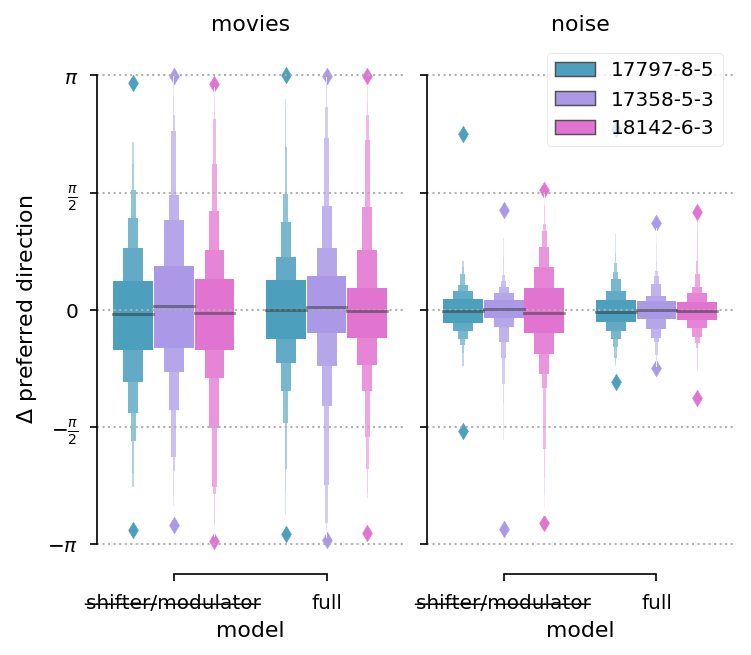

In [14]:
sns.set_context('paper', font_scale=1.2)
sns.set_palette(scan_cmap)
g = sns.factorplot("model",  r'$\Delta \phi$', hue='scan', data=df,  kind='lv', col='train_data', legend=False, order=[strike('shifter/modulator'), "full"])
g.fig.set_dpi(150)
g.axes[0,0].set_yticks(np.linspace(-1, 1, 5) * np.pi)
g.axes[0,0].set_yticklabels([r'$-\pi$', r'$-\frac{3\pi}{4}$', r'$-\frac{\pi}{2}$',  r'$-\frac{\pi}{4}$', '0',  r'$\frac{\pi}{4}$', r'$\frac{\pi}{2}$', r'$\frac{3\pi}{4}$', r'$\pi$'][::2])
g.axes[0,0].set_ylabel(r'$\Delta$ preferred direction')
g.axes[0,0].yaxis.grid(linestyle=':', zorder=-20, lw=1)
g.axes[0,1].yaxis.grid(linestyle=':', zorder=-20, lw=1)
g.axes[0,1].legend(ncol=1, loc='upper right')
g.set_titles("{col_name}")
g.fig.set_size_inches((5,5))
g.fig.subplots_adjust(bottom=.2, left=.125)

sns.despine(trim=True)
g.fig.savefig('figures/delta_dir_lv.png', dpi=200)

In [15]:
from scipy.stats import levene

def test(d):
    return pd.Series({'p-value':levene(d['full'], d[strike('shifter/modulator')])[1]})

df2 = df.groupby(['train_data', 'scan', 'model'])[r'$\Delta \phi$'].std().unstack('model')
df2['ratio'] = df2.loc[:, strike('shifter/modulator')]/df2.loc[:, 'full']

df3 = df.set_index(['train_data', 'scan','unit_id',  'model'])[r'$\Delta \phi$'].unstack('model').reset_index()
df3 = df3.groupby(['train_data', 'scan']).apply(test)
df2['p-value'] = df3['p-value']
df2

model                     full  s̶h̶i̶f̶t̶e̶r̶/̶m̶o̶d̶u̶l̶a̶t̶o̶r̶     ratio  \
train_data scan                                                                
movies     17358-5-3  0.975172                            1.005469  1.031068   
           17797-8-5  0.795917                            0.848635  1.066236   
           18142-6-3  0.877795                            0.981232  1.117837   
noise      17358-5-3  0.240392                            0.349430  1.453586   
           17797-8-5  0.280545                            0.275821  0.983162   
           18142-6-3  0.267444                            0.604326  2.259633   

model                      p-value  
train_data scan                     
movies     17358-5-3  2.084000e-01  
           17797-8-5  3.627082e-02  
           18142-6-3  5.893290e-02  
noise      17358-5-3  2.054039e-01  
           17797-8-5  9.742109e-01  
           18142-6-3  2.306993e-14

# Plot tuning curves

In [3]:
group_ids = [21, 22, 23]
group_constr = 'group_id in ({})'.format(','.join(tuple(map(str, group_ids))))

network_config = dj.AndList([
    {    'core_hash': '22d11147b37e3947e7d1034cc00d402c', # 12 x 36
         'mod_hash': '4954311aa3bebb347ebf411ab5198890',
         'seed': 2606,
         'shift_hash': '64add03e1462b7413b59812d446aee9f',
         'train_hash': '624f62a2ef01d39f6703f3491bb9242b', # batchsize=8 stop gradient
         'ro_hash':'bf00321c11e46d68d4a42653a725969d', # 2 and 4 
        },
    'data_hash in ("5253599d3dceed531841271d6eeba9c5", "6c0290da908317e55c4baf92e379d651")',
    group_constr
])
    


In [4]:
tuning.MonetCurve() & network_config

group_id index of group,core_hash unique identifier for configuration,ro_hash unique identifier for configuration,shift_hash unique identifier for configuration,mod_hash unique identifier for configuration,data_hash unique identifier for configuration,train_hash unique identifier for configuration,seed random seed,latency (s) screen-to-brain latency,duration (s) total duration of applicable trials,directions directions presented,n number of sample points per direction
21,22d11147b37e3947e7d1034cc00d402c,bf00321c11e46d68d4a42653a725969d,64add03e1462b7413b59812d446aee9f,4954311aa3bebb347ebf411ab5198890,5253599d3dceed531841271d6eeba9c5,624f62a2ef01d39f6703f3491bb9242b,2606,0.05,7.504,=BLOB=,=BLOB=
21,22d11147b37e3947e7d1034cc00d402c,bf00321c11e46d68d4a42653a725969d,64add03e1462b7413b59812d446aee9f,4954311aa3bebb347ebf411ab5198890,6c0290da908317e55c4baf92e379d651,624f62a2ef01d39f6703f3491bb9242b,2606,0.05,7.504,=BLOB=,=BLOB=
22,22d11147b37e3947e7d1034cc00d402c,bf00321c11e46d68d4a42653a725969d,64add03e1462b7413b59812d446aee9f,4954311aa3bebb347ebf411ab5198890,5253599d3dceed531841271d6eeba9c5,624f62a2ef01d39f6703f3491bb9242b,2606,0.05,7.504,=BLOB=,=BLOB=
22,22d11147b37e3947e7d1034cc00d402c,bf00321c11e46d68d4a42653a725969d,64add03e1462b7413b59812d446aee9f,4954311aa3bebb347ebf411ab5198890,6c0290da908317e55c4baf92e379d651,624f62a2ef01d39f6703f3491bb9242b,2606,0.05,7.504,=BLOB=,=BLOB=
23,22d11147b37e3947e7d1034cc00d402c,bf00321c11e46d68d4a42653a725969d,64add03e1462b7413b59812d446aee9f,4954311aa3bebb347ebf411ab5198890,5253599d3dceed531841271d6eeba9c5,624f62a2ef01d39f6703f3491bb9242b,2606,0.05,7.504,=BLOB=,=BLOB=
23,22d11147b37e3947e7d1034cc00d402c,bf00321c11e46d68d4a42653a725969d,64add03e1462b7413b59812d446aee9f,4954311aa3bebb347ebf411ab5198890,6c0290da908317e55c4baf92e379d651,624f62a2ef01d39f6703f3491bb9242b,2606,0.05,7.504,=BLOB=,=BLOB=


In [5]:
constr_cell = tuning.Ori.Cell() & dict(stimulus_type="stimulus.Monet2", ori_type='dir', spike_method=5, segmentation_method=3) \
                              & '1/(2/selectivity - 1) > .2 and r2 > 0.005' & (data.MovieMultiDataset.Member() & group_constr)
rel_curve = tuning.DirCurve() * tuning.DirCurve.Cell() * constr_cell
df_curve = pd.DataFrame(rel_curve.fetch(order_by='r2 DESC'))


In [6]:
rel_model = (tuning.MonetCurve() * tuning.MonetCurve.Cell() * models.Encoder.UnitTestScores()).proj(
            'pearson', 
            model_directions='directions', 
            model_curve='curve', 
            train_data='IF(data_hash = "5253599d3dceed531841271d6eeba9c5", "movies", "noise")')  & network_config
df_model = pd.DataFrame(rel_model.fetch())

df = df_curve.merge(df_model, on=['animal_id', 'session', 'scan_idx', 'unit_id'])


In [7]:
def get_movie_rank(df):
    df1 = df[df.train_data == "movies"].sort_values("unit_id")
    df2 = df[df.train_data == "noise"].sort_values("unit_id")
    rank = np.array(np.argsort(-df1.pearson))
    df1['score_rank'] = rank
    df2['score_rank'] = rank
    tmp =  pd.concat([df1, df2]).drop(['animal_id', 'session', 'scan_idx'], axis=1)
    return tmp

df2 = df.groupby(['animal_id', 'session', 'scan_idx']).apply(get_movie_rank).reset_index()
df2['scan'] = ['{animal_id}-{session}-{scan_idx}'.format(**r.to_dict()) for _, r in df2.iterrows()]


In [9]:
df2[df2.score_rank < N]

,animal_id,session,scan_idx,level_3,pipe_version,field,channel,segmentation_method,spike_method,stimulus_type,...,data_hash,train_hash,seed,preproc_id,pearson,model_curve,train_data,model_directions,score_rank,scan
5,17358,5,3,112,1,1,1,3,5,stimulus.Monet2,...,5253599d3dceed531841271d6eeba9c5,624f62a2ef01d39f6703f3491bb9242b,2606,1,0.275934,"[2.715003323214518, 2.149027486642202, 3.78416...",movies,"[0.0, 0.3927, 0.7854, 1.1781, 1.5708, 1.9635, ...",5,17358-5-3
9,17358,5,3,354,1,1,1,3,5,stimulus.Monet2,...,5253599d3dceed531841271d6eeba9c5,624f62a2ef01d39f6703f3491bb9242b,2606,1,0.060028,"[0.46213788682580087, 0.5010652733309303, 0.82...",movies,"[0.0, 0.3927, 0.7854, 1.1781, 1.5708, 1.9635, ...",7,17358-5-3
12,17358,5,3,142,1,2,1,3,5,stimulus.Monet2,...,5253599d3dceed531841271d6eeba9c5,624f62a2ef01d39f6703f3491bb9242b,2606,1,0.272485,"[8.19650239472588, 12.400873042095235, 6.21840...",movies,"[0.0, 0.3927, 0.7854, 1.1781, 1.5708, 1.9635, ...",6,17358-5-3
18,17358,5,3,52,1,3,1,3,5,stimulus.Monet2,...,5253599d3dceed531841271d6eeba9c5,624f62a2ef01d39f6703f3491bb9242b,2606,1,0.221956,"[1.8820008857831605, 0.692703499970045, 1.6490...",movies,"[0.0, 0.3927, 0.7854, 1.1781, 1.5708, 1.9635, ...",2,17358-5-3
26,17358,5,3,328,1,3,1,3,5,stimulus.Monet2,...,5253599d3dceed531841271d6eeba9c5,624f62a2ef01d39f6703f3491bb9242b,2606,1,0.058609,"[6.28955118647108, 4.175477700052308, 5.605710...",movies,"[0.0, 0.3927, 0.7854, 1.1781, 1.5708, 1.9635, ...",0,17358-5-3
27,17358,5,3,98,1,3,1,3,5,stimulus.Monet2,...,5253599d3dceed531841271d6eeba9c5,624f62a2ef01d39f6703f3491bb9242b,2606,1,0.094096,"[4.746470282701419, 5.9757202536452025, 4.8220...",movies,"[0.0, 0.3927, 0.7854, 1.1781, 1.5708, 1.9635, ...",11,17358-5-3
28,17358,5,3,208,1,3,1,3,5,stimulus.Monet2,...,5253599d3dceed531841271d6eeba9c5,624f62a2ef01d39f6703f3491bb9242b,2606,1,0.108692,"[2.4131237936856, 1.2428134866058829, 1.675868...",movies,"[0.0, 0.3927, 0.7854, 1.1781, 1.5708, 1.9635, ...",10,17358-5-3
32,17358,5,3,334,1,4,1,3,5,stimulus.Monet2,...,5253599d3dceed531841271d6eeba9c5,624f62a2ef01d39f6703f3491bb9242b,2606,1,0.072672,"[0.6155076105818318, 0.7122975400849885, 0.831...",movies,"[0.0, 0.3927, 0.7854, 1.1781, 1.5708, 1.9635, ...",8,17358-5-3
36,17358,5,3,220,1,4,1,3,5,stimulus.Monet2,...,5253599d3dceed531841271d6eeba9c5,624f62a2ef01d39f6703f3491bb9242b,2606,1,0.131131,"[4.149371328574975, 1.8582225795104805, 3.0782...",movies,"[0.0, 0.3927, 0.7854, 1.1781, 1.5708, 1.9635, ...",9,17358-5-3
38,17358,5,3,18,1,4,1,3,5,stimulus.Monet2,...,5253599d3dceed531841271d6eeba9c5,624f62a2ef01d39f6703f3491bb9242b,2606,1,0.040004,"[1.024167427089906, 1.740041006648657, 0.67826...",movies,"[0.0, 0.3927, 0.7854, 1.1781, 1.5708, 1.9635, ...",3,17358-5-3


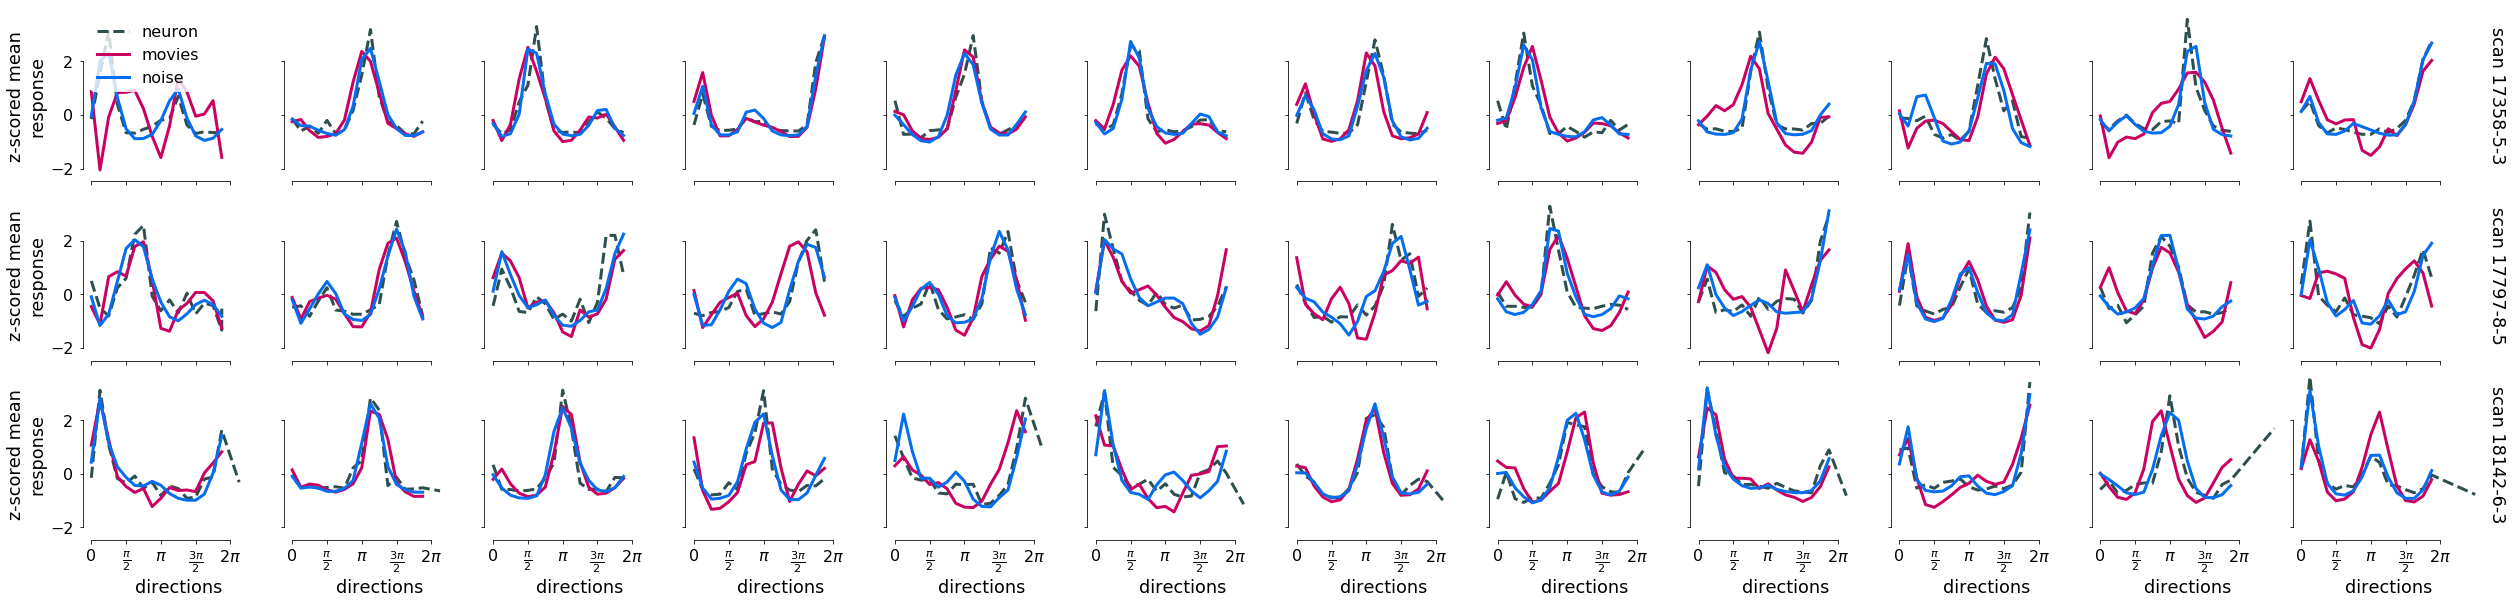

In [11]:
N = 12
sns.set_palette(scan_cmap)
sns.set_context('paper', font_scale=2)
def plot_ori(d, dm, c, cm, zscore=True, **kwargs):
    label = kwargs.pop('label')
    kwargs.pop('color')

    c = c.iloc[0]
    cm = cm.iloc[0]
    if zscore:
        c = (c - c.mean())/c.std()
        cm = (cm - cm.mean())/cm.std()
    if label == 'movies':
        plt.plot(d.iloc[0], c, '--', color='darkslategray', label='neuron', zorder=-10, **kwargs)
    plt.plot(dm.iloc[0], cm, label=label, color=sns.xkcd_rgb['cerulean blue'] if label == 'noise' else sns.xkcd_rgb['deep pink'],  **kwargs)
    ax = plt.gca()
    ax.set_xticks([0,np.pi/2,np.pi, 3* np.pi/2,2*np.pi])
    ax.set_xticklabels(['0', r'$\frac{\pi}{2}$', r'$\pi$', r'$\frac{3\pi}{2}$', r'$2\pi$'])

g = sns.FacetGrid(df2[df2.score_rank < N], row='scan', col='score_rank', hue='train_data', margin_titles=False, col_order=np.arange(12))
g.map(plot_ori, "directions",  "model_directions", "curve", "model_curve", lw=3)
g.set_axis_labels("directions", "z-scored mean\nresponse")
g.set_titles(template="", col_template="", row_template="")
g._margin_titles = True
g.set_titles(template="", col_template="", row_template="{row_var} {row_name}")
leg = g.axes[0,0].legend(loc="upper left", ncol=1)
leg.get_frame().set_linewidth(0.0)
sns.despine(trim=True)
# g.fig.tight_layout()
g.fig.subplots_adjust(wspace=.05, hspace=.05)
g.fig.savefig('figures/direction_tuning.png', dpi=200)

# Receptive fields

In [35]:
group_ids = [21, 22, 23]
group_constr = 'group_id in ({})'.format(','.join(tuple(map(str, group_ids))))

network_config = dj.AndList([
    {    'core_hash': '22d11147b37e3947e7d1034cc00d402c', # 12 x 36
         'mod_hash': '4954311aa3bebb347ebf411ab5198890',
         'seed': 2606,
         'shift_hash': '64add03e1462b7413b59812d446aee9f',
         'train_hash': '624f62a2ef01d39f6703f3491bb9242b', # batchsize=8 stop gradient
         'ro_hash':'bf00321c11e46d68d4a42653a725969d', # 2 and 4 
        },
    'data_hash in ("5253599d3dceed531841271d6eeba9c5", "6c0290da908317e55c4baf92e379d651")',
    group_constr
])
    


[autoreload of nips2018.movie.analysis.tuning failed: Traceback (most recent call last):
  File "/usr/local/lib/python3.5/dist-packages/IPython/extensions/autoreload.py", line 244, in check
    superreload(m, reload, self.old_objects)
  File "/usr/local/lib/python3.5/dist-packages/IPython/extensions/autoreload.py", line 390, in superreload
    update_generic(old_obj, new_obj)
  File "/usr/local/lib/python3.5/dist-packages/IPython/extensions/autoreload.py", line 329, in update_generic
    update(a, b)
  File "/usr/local/lib/python3.5/dist-packages/IPython/extensions/autoreload.py", line 287, in update_class
    if update_generic(old_obj, new_obj): continue
  File "/usr/local/lib/python3.5/dist-packages/IPython/extensions/autoreload.py", line 329, in update_generic
    update(a, b)
  File "/usr/local/lib/python3.5/dist-packages/IPython/extensions/autoreload.py", line 287, in update_class
    if update_generic(old_obj, new_obj): continue
  File "/usr/local/lib/python3.5/dist-packages/IPyt

In [36]:
tuning.STA() & network_config

group_id index of group,core_hash unique identifier for configuration,ro_hash unique identifier for configuration,shift_hash unique identifier for configuration,mod_hash unique identifier for configuration,data_hash unique identifier for configuration,train_hash unique identifier for configuration,seed random seed,nbins number of lags at which maps were calculated,bin_size (secs) size of the bins.,total_duration (secs) total duration of included trials,vmax correlation value of int8 level at 127
21,22d11147b37e3947e7d1034cc00d402c,bf00321c11e46d68d4a42653a725969d,64add03e1462b7413b59812d446aee9f,4954311aa3bebb347ebf411ab5198890,5253599d3dceed531841271d6eeba9c5,624f62a2ef01d39f6703f3491bb9242b,2606,5,0.100,840.00,0.4
21,22d11147b37e3947e7d1034cc00d402c,bf00321c11e46d68d4a42653a725969d,64add03e1462b7413b59812d446aee9f,4954311aa3bebb347ebf411ab5198890,6c0290da908317e55c4baf92e379d651,624f62a2ef01d39f6703f3491bb9242b,2606,5,0.100,840.00,0.4
22,22d11147b37e3947e7d1034cc00d402c,bf00321c11e46d68d4a42653a725969d,64add03e1462b7413b59812d446aee9f,4954311aa3bebb347ebf411ab5198890,5253599d3dceed531841271d6eeba9c5,624f62a2ef01d39f6703f3491bb9242b,2606,5,0.100,840.00,0.4
22,22d11147b37e3947e7d1034cc00d402c,bf00321c11e46d68d4a42653a725969d,64add03e1462b7413b59812d446aee9f,4954311aa3bebb347ebf411ab5198890,6c0290da908317e55c4baf92e379d651,624f62a2ef01d39f6703f3491bb9242b,2606,5,0.100,840.00,0.4
23,22d11147b37e3947e7d1034cc00d402c,bf00321c11e46d68d4a42653a725969d,64add03e1462b7413b59812d446aee9f,4954311aa3bebb347ebf411ab5198890,5253599d3dceed531841271d6eeba9c5,624f62a2ef01d39f6703f3491bb9242b,2606,5,0.100,840.00,0.4
23,22d11147b37e3947e7d1034cc00d402c,bf00321c11e46d68d4a42653a725969d,64add03e1462b7413b59812d446aee9f,4954311aa3bebb347ebf411ab5198890,6c0290da908317e55c4baf92e379d651,624f62a2ef01d39f6703f3491bb9242b,2606,5,0.100,840.00,0.4


In [38]:
constr_cell = tuning.NeuroSTAQual()  & dict(stimulus_type="stimulus.Monet2", spike_method=5, segmentation_method=3) \
                              & 'snr > 6' & (data.MovieMultiDataset.Member() & group_constr)
rel_sta_neuron = tuning.NeuroSTA.Map() * constr_cell
df_sta = pd.DataFrame(rel_sta_neuron.fetch(order_by='snr DESC'))


In [39]:
rel_model = (tuning.STA() * tuning.STA.Map() * models.Encoder.UnitTestScores()).proj(
            'pearson', 
            model_map='map', 
            train_data='IF(data_hash = "5253599d3dceed531841271d6eeba9c5", "movies", "noise")')  & network_config
df_model = pd.DataFrame(rel_model.fetch())



In [40]:
tmp1 = pd.DataFrame(df_model[df_model.train_data == "movies"])
tmp2 = pd.DataFrame(df_model[df_model.train_data == "noise"])
df3 = tmp1.merge(tmp2, on=['animal_id', 'session', 'scan_idx','unit_id'], suffixes=('_movies', '_noise'))


In [41]:
df = df_sta.merge(df3, on=['animal_id', 'session', 'scan_idx', 'unit_id'])

def get_rank(df):
    rank = np.array(np.argsort(-df.pearson_movies))
    df['score_rank'] = rank
    return df

df2 = df.groupby(['animal_id', 'session', 'scan_idx']).apply(get_rank).reset_index()
df2['scan'] = ['{animal_id}-{session}-{scan_idx}'.format(**r.to_dict()) for _, r in df2.iterrows()]


In [42]:
df2[:10]

,index,animal_id,session,scan_idx,pipe_version,field,channel,segmentation_method,spike_method,stimulus_type,...,mod_hash_noise,data_hash_noise,train_hash_noise,seed_noise,preproc_id_noise,pearson_noise,model_map_noise,train_data_noise,score_rank,scan
0,0,18142,6,3,1,4,1,3,5,stimulus.Monet2,...,4954311aa3bebb347ebf411ab5198890,6c0290da908317e55c4baf92e379d651,624f62a2ef01d39f6703f3491bb9242b,2606,1,0.427222,"[[[-1, 0, 0, 0, 0], [-1, 0, 0, 0, 1], [0, 1, 3...",noise,66,18142-6-3
1,1,18142,6,3,1,4,1,3,5,stimulus.Monet2,...,4954311aa3bebb347ebf411ab5198890,6c0290da908317e55c4baf92e379d651,624f62a2ef01d39f6703f3491bb9242b,2606,1,0.377171,"[[[0, 1, 1, 0, 0], [2, 2, 2, 2, 1], [6, 5, 5, ...",noise,1,18142-6-3
2,2,17797,8,5,1,6,1,3,5,stimulus.Monet2,...,4954311aa3bebb347ebf411ab5198890,6c0290da908317e55c4baf92e379d651,624f62a2ef01d39f6703f3491bb9242b,2606,1,0.132042,"[[[0, 1, 3, 4, 3], [0, 0, 0, 0, 0], [-2, -2, -...",noise,45,17797-8-5
3,3,18142,6,3,1,4,1,3,5,stimulus.Monet2,...,4954311aa3bebb347ebf411ab5198890,6c0290da908317e55c4baf92e379d651,624f62a2ef01d39f6703f3491bb9242b,2606,1,0.203180,"[[[4, 3, 2, 1, 1], [5, 5, 4, 3, 1], [4, 4, 3, ...",noise,18,18142-6-3
4,4,18142,6,3,1,4,1,3,5,stimulus.Monet2,...,4954311aa3bebb347ebf411ab5198890,6c0290da908317e55c4baf92e379d651,624f62a2ef01d39f6703f3491bb9242b,2606,1,0.406134,"[[[-3, -2, -4, -4, -3], [-3, -2, -3, -3, -1], ...",noise,47,18142-6-3
5,5,18142,6,3,1,4,1,3,5,stimulus.Monet2,...,4954311aa3bebb347ebf411ab5198890,6c0290da908317e55c4baf92e379d651,624f62a2ef01d39f6703f3491bb9242b,2606,1,0.072431,"[[[6, 5, 5, 4, 3], [3, 2, 2, 2, 2], [4, 4, 4, ...",noise,40,18142-6-3
6,6,17797,8,5,1,6,1,3,5,stimulus.Monet2,...,4954311aa3bebb347ebf411ab5198890,6c0290da908317e55c4baf92e379d651,624f62a2ef01d39f6703f3491bb9242b,2606,1,0.343547,"[[[-2, -2, -1, -1, -1], [1, 3, 4, 4, 3], [1, 2...",noise,5,17797-8-5
7,7,18142,6,3,1,4,1,3,5,stimulus.Monet2,...,4954311aa3bebb347ebf411ab5198890,6c0290da908317e55c4baf92e379d651,624f62a2ef01d39f6703f3491bb9242b,2606,1,0.298801,"[[[-4, -3, -2, -2, -4], [-9, -9, -9, -8, -7], ...",noise,4,18142-6-3
8,8,18142,6,3,1,3,1,3,5,stimulus.Monet2,...,4954311aa3bebb347ebf411ab5198890,6c0290da908317e55c4baf92e379d651,624f62a2ef01d39f6703f3491bb9242b,2606,1,0.523677,"[[[3, 3, 1, 0, 1], [4, 4, 2, 0, 1], [3, 2, 0, ...",noise,7,18142-6-3
9,9,17797,8,5,1,3,1,3,5,stimulus.Monet2,...,4954311aa3bebb347ebf411ab5198890,6c0290da908317e55c4baf92e379d651,624f62a2ef01d39f6703f3491bb9242b,2606,1,0.285555,"[[[5, 5, 4, 2, 0], [0, 0, -1, -2, -3], [-5, -5...",noise,39,17797-8-5


/usr/local/lib/python3.5/dist-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/usr/local/lib/python3.5/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


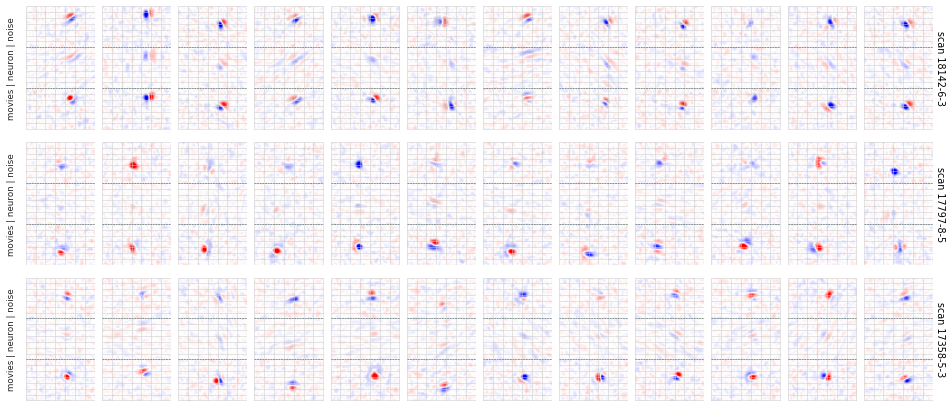

In [43]:
from functools import partial

def preprocess(rf, lag):
    assert len(rf) == 1
    rf = rf.iloc[0]
    rf = rf[..., :lag].mean(axis=-1)
    return rf
    

N = 12
lag = 3
sns.set_context('paper', font_scale=1.0)
def plot_rf(rf_natural, rf_neuron, rf_noise, lag=1, v=65, g=7, **kwargs):
    kwargs.pop('color')
    rf_natural, rf_neuron, rf_noise = map(partial(preprocess, lag=lag), [rf_natural, rf_neuron, rf_noise])

    if not rf_neuron.shape[0] / rf_natural.shape[0] == rf_neuron.shape[1] / rf_natural.shape[1]:
        if rf_neuron.shape == (126, 216):
            rf_neuron = rf_neuron[4:4 + 117, 4:4 + 208]
   
    shape = rf_neuron.shape
    ax = plt.gca()
    tmp1 = resize(rf_natural, shape, preserve_range=True) 
    tmp2 = resize(rf_noise, shape, preserve_range=True) 
    tmp = np.vstack((tmp1, rf_neuron, tmp2))
    ax.matshow(tmp, vmin=-v, vmax=v, **kwargs)
    y, x = shape
    yt = np.linspace(0,3*y,3*g + 1)
    ax.set_xticks(np.linspace(0,x,g+1))
    ax.set_yticks(yt)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.plot([0,x], [y,y], '--', color='darkslategray',lw=.5)
    ax.plot([0,x], [2 * y,2 * y], '--',color='darkslategray',lw=.5)
    ax.axis('tight')
    ax.axis([0,x+1, -1,3*y])
    ax.grid(lw=.5)
    

with sns.axes_style('whitegrid'):
    g = sns.FacetGrid(df2[df2.score_rank < N], row='scan', col='score_rank', margin_titles=False)
    g.map(plot_rf, "model_map_movies", "map", "model_map_noise", lag=lag, cmap='bwr', v=90)
g.set_axis_labels("", "")
g.set_titles(template="", col_template="", row_template="")
# g._margin_titles = True
# g.set_titles(template="", col_template="", row_template="{row_var} {row_name}")

for ax, rowlab in zip(g.axes[:, -1], g.row_names):
    ax.text(1.1, 0.5, 'scan ' + rowlab, horizontalalignment='center',verticalalignment='center', transform=ax.transAxes, rotation=-90)

g.set_ylabels('movies | neuron | noise')
# leg = g.axes[0,0].legend(loc="upper left")
# leg.get_frame().set_linewidth(0.0)
sns.despine(left=True, bottom=True)

g.fig.set_size_inches((14,6))
g.fig.subplots_adjust(left=.05, hspace=.1, wspace=.1, right=0.95)
g.fig.savefig('figures/receptive_fields.png', dpi=200)